In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
import seaborn as sns
from random import sample


In [3]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [4]:

#plt.rcParams['figure.figsize'] = [8.0, 8.0]
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams["axes.labelsize"] = 20
#plt.rcParams["legend.fontsize"] = 22

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  #

In [5]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
bn = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
bn_proc = make_fn(processings,bn)


# Get loss data

In [6]:
#select simulation
modlist = modlist_allscen+modlist_ssp585
modset = 'ssp585'
regions1 = ['UK','WEU','SEU','NOR','EEU'] #leave empty for EU
regions2 = ['BI','IP','FR','MID','MED','SC','EEU']
regions3 = ['BI','IP','FR','WEU','MED','SC','EEU']
reglist = regions3
periods = ['historical','ssp585']
impf_namelist = ['CubEOT','Em2011','Sw2010']
caltype = 'AAI_EMDAT_100mn'
simname = 'stacked'
pp_func_dic = pp_func_dic_diff


In [7]:
#initiate df to save results
metrics = [1,10,20]
metnames = [str(rp)+'yr_RP' for rp in metrics]
#metrics = [1]
#metnames = ["1 yr impact"]
iterables = [metnames,periods,impf_namelist]
col_idx1 = pd.MultiIndex.from_product(iterables,names=["metric","period","Impf"])
res_df = pd.DataFrame(columns=col_idx1,index=modlist)  


In [8]:
# import impact data
dict_res = {}
res_list = []
for reg in reglist:
    #initiate dfs
    res_df = pd.DataFrame(columns=col_idx1,index=modlist)  
    
    for modid, modname in enumerate(modlist):
        for period in periods:
            for impf in impf_namelist:
                
                #make file names
                #pp_funcname = str(pp_func_dic[impf]).split(" ")[1]
                if impf == 'CubEOT':
                    pp_funcname = 'scale_qt'
                else:
                    pp_funcname = 'diff_qt'
                
                savenameimp = make_fn([impf,caltype,pp_funcname],bn_proc)
                impfn = make_fn(['imp',simname,reg,period,modname],savenameimp,filetype='.csv')
                
                #import impacts
                imp = Impact()
                imp = imp.from_csv(pathimp+"impact csv/regional/stacked/"+reg+"/"+period+"/"+impfn)
                #imp.imp_mat = imp.read_sparse_csr(impmatfn)
                for idm, metric in enumerate(metrics):
                    if metric == 'aai_agg':
                        stat = imp.aai_agg
                    else:  
                        stat = imp.calc_freq_curve(return_per=metric).impact
                    res_df.loc[modname,(metnames[idm],period,impf)] = stat
                    #reg_df.loc[modname,(reg,metnames[idm],period,impf)] = stat
    
    res_df = res_df.astype(np.float64)
    #reg_df = reg_df.astype(np.float64)

    if reg == '':
        reg = 'EU'
    dict_res[reg] = [res_df]
    res_list.append(res_df)
reg_df = pd.concat(res_list,keys=reglist,names=['region'],axis=1)

## Plot Multimodel spread

In [11]:
metnames

['1yr_RP', '10yr_RP', '20yr_RP']

In [56]:
#select data
idx = pd.IndexSlice
met_set = metnames
nmets = len(met_set)
impf_set = impf_namelist
sel_reg = regions3
subset_df = reg_df.loc[:,idx[sel_reg,:,:,impf_set]]
diff_df = subset_df.loc[:,idx[:,:,"ssp585"]]-subset_df.loc[:,idx[:,:,"historical"]].values
diff_rel_df = 100*diff_df.div(subset_df.loc[:,idx[:,:,"historical"]].values)
#subset impf
impfi = "Em2011"
diff_df_ss = diff_rel_df.loc[:,idx[:,:,:,impfi]].copy()
diff_df_ss.columns = diff_df_ss.columns.droplevel((2,3))
diff_df_ss.index.name = "model"
diff_df_ss.columns.name = "reg"

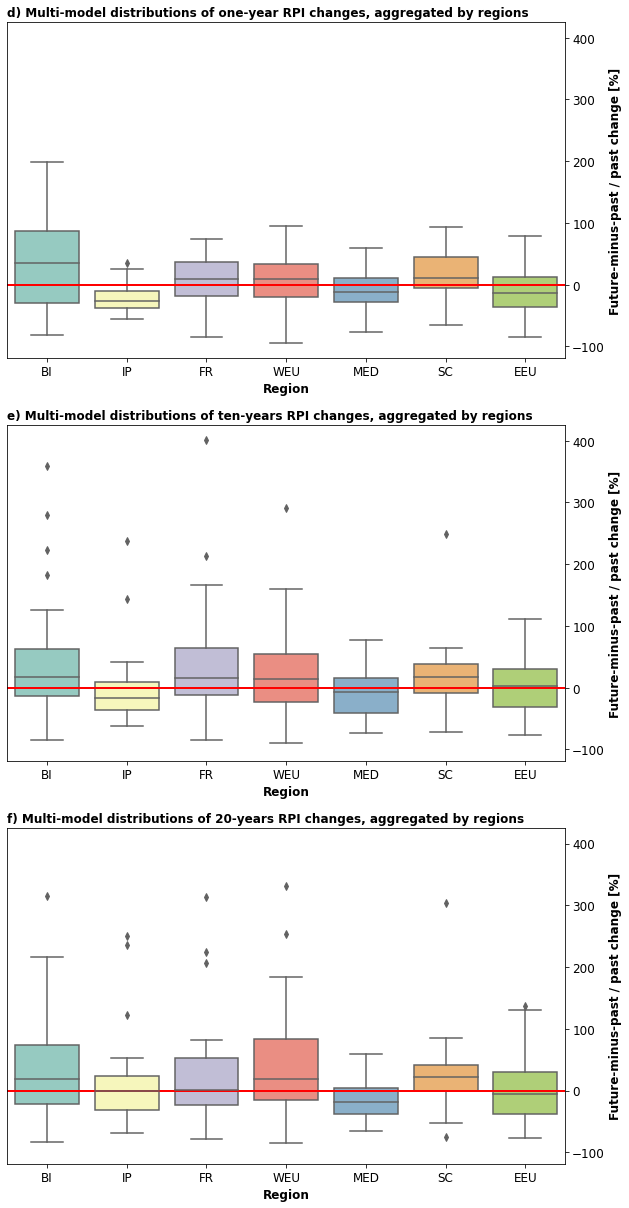

In [59]:
stacked_all = pd.DataFrame(diff_df_ss.stack(level="region")).reset_index()

#plotting params
saving = True
savelocation="results/figures/Impacts/boxplots/"
savenameimp = make_fn([impfi,caltype],bn_proc)
savefileName = make_fn(['reg','bp']+met_set+[periods[1]+'-'+periods[0],simname],savenameimp,filetype='.png')
titles = ['d) Multi-model distributions of one-year RPI changes, aggregated by regions ',
         'e) Multi-model distributions of ten-years RPI changes, aggregated by regions ',
         'f) Multi-model distributions of 20-years RPI changes, aggregated by regions ']
#labels option
ttsize = 12
sublabsize = 12
gllabsize = 8
cbarlabsize = 12
cbarticksize = 12

#initiate fig
fig = plt.figure(figsize=(10,nmets*7))
axs = fig.subplots(nrows=nmets,ncols=1,sharey=True,sharex=False)
try:
    for i,ax in enumerate(axs):
        met = met_set[i]
        sns.boxplot(ax=ax,x="region",order=reglist, y=met,data=stacked_all,palette="Set3")#palette="Set3"
        ax.axhline(0,linewidth=2,color="r")
        ax.set_ylabel('Fut-past change (%)')
        ax.set_title(titles[i],loc='left',fontsize = cbarticksize,fontweight='bold')
        ax.set_ylabel('Future-minus-past / past change [%]',fontsize = cbarticksize,fontweight='bold')#,fontweight='bold'
        ax.set_xlabel('Region',fontsize = cbarticksize,fontweight='bold')#,fontweight='bold'
        ax.set_title(titles[i],loc='left',fontsize = ttsize,fontweight='bold')
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.tick_params(axis='y', labelsize=cbarticksize)
        #plt.yticks(fontsize=14)
        ax.tick_params(axis='x', labelsize=cbarticksize)
        #plt.xticks(fontsize=14)

except:
    met = met_set[0]
    i=0
    ax = axs
    sns.boxplot(ax=ax,x="region", order=reglist,y=met,data=stacked_all,palette="Set3")
    ax.axhline(0,linewidth=2,color="r")
    ax.set_ylabel('Future-minus-past / past change [%]',fontsize = sublabsize,fontweight='bold')#,fontweight='bold'
    ax.set_xlabel('Region',fontsize = sublabsize,fontweight='bold')#,fontweight='bold'
    ax.set_title(titles[i],loc='left',fontsize = ttsize,fontweight='bold')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', labelsize=cbarticksize)
    #plt.yticks(fontsize=14)
    ax.tick_params(axis='x', labelsize=cbarticksize)
    #plt.xticks(fontsize=14)

if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

## Subsetting models

### Load and process indices

In [27]:
#get sfcT
sfcT_fn = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
sfcT = pd.read_csv(pathcirc+sfcT_fn,header=[0],index_col=[0,1]).loc[:,["sfcT"]]

#get remote indices
dind_fn1 = "diff_all_remote_indices_O20_sp_avg_allmods_historical_ssp585.csv"
dind_fn2 = "diff_custom_indices_sp_avg_allmods_historical_ssp585.csv"
dind_fn3 = "diff_weather_indices_CU21_sp_avg_allmods_historical_ssp585.csv"


preds0 = ["pol","trop","strat"]
preds1 = ["pol","trop","strat","NAWH","Nino4-Nino3"]
preds2 = ["baro","TCWV"]
preds3 = ["NAO","EA","EAWR","SCA"]
dind_df1 = pd.read_csv(pathcirc+dind_fn1,header=[0],index_col=[0,1]).iloc[:,1:]
dind_df2 = pd.read_csv(pathcirc+dind_fn2,header=[0],index_col=[0,1])
dind_df3 = pd.read_csv(pathcirc+dind_fn3,header=[0],index_col=[0,1])

#concat 
dind_df_all = pd.concat([dind_df1,dind_df2,dind_df3],axis=1)

In [28]:
#remove first member of KACE because outlier
dind_df_all_rm = dind_df_all.drop(('KACE-1-0-G',0),axis=0)
#reg_aai_df_rm = reg_aai_df.drop(('KACE-1-0-G',0),axis=0)
sfcT_rm = sfcT.drop(('KACE-1-0-G',0),axis=0)

In [29]:
##prepare predictors
#select df
preds = dind_df_all_rm.columns.tolist()
sel_dind_memsep_df = dind_df_all_rm.copy().loc[modlist,preds]
sel_sfcT_memsep = sfcT_rm.loc[modlist]

#memmean 
sel_dind_df = sel_dind_memsep_df.groupby("model").mean()
sel_sfcT = sel_sfcT_memsep.groupby("model").mean()

#normalize by sfcT
sel_dind_df.loc[:,preds] = sel_dind_df.loc[:,preds] / sel_sfcT.values

# anomalies
an_dind_df = sel_dind_df.copy()
an_dind_df = sel_dind_df.loc[:,preds]-sel_dind_df.loc[:,preds].mean()

# standardized
std_an_dind_df = an_dind_df.copy()
std_an_dind_df.loc[:,preds] = an_dind_df/sel_dind_df.std()

### Select models

In [30]:
ind_df = std_an_dind_df
indices = ind_df.columns.tolist()
threshold = 0.5
modscen_dict = {}
for indice in indices:
    posmods = ind_df.where(ind_df[indice]>threshold).dropna(how="all").index.tolist()
    negmods = ind_df.where(ind_df[indice]<-threshold).dropna(how="all").index.tolist()
    cirscen = [indice+r'$\uparrow$',indice+r'$\downarrow$']
    modscen_dict[cirscen[0]] = posmods
    modscen_dict[cirscen[1]] = negmods
    print(cirscen[0]+": "+str(len(posmods))+" models" )
    print(cirscen[1]+": "+str(len(negmods))+" models" )

pol$\uparrow$: 8 models
pol$\downarrow$: 9 models
trop$\uparrow$: 10 models
trop$\downarrow$: 10 models
strat$\uparrow$: 9 models
strat$\downarrow$: 9 models
NAWH$\uparrow$: 10 models
NAWH$\downarrow$: 9 models
Nino4-Nino3$\uparrow$: 6 models
Nino4-Nino3$\downarrow$: 10 models
baro$\uparrow$: 5 models
baro$\downarrow$: 11 models
TCWV$\uparrow$: 9 models
TCWV$\downarrow$: 9 models
NAO$\uparrow$: 8 models
NAO$\downarrow$: 8 models
EA$\uparrow$: 11 models
EA$\downarrow$: 9 models
EAWR$\uparrow$: 10 models
EAWR$\downarrow$: 9 models
SCA$\uparrow$: 9 models
SCA$\downarrow$: 8 models


In [35]:
#pick only positive or negative phases for each indice
ind_df = std_an_dind_df
indices = ind_df.columns.tolist()
threshold = 0.5
modscen_dict2 = {}
for indice in indices:
    posmods = ind_df.where(ind_df[indice]>threshold).dropna(how="all").index.tolist()
    negmods = ind_df.where(ind_df[indice]<-threshold).dropna(how="all").index.tolist()
    #cirscen = [indice+r'$\uparrow$',indice+r'$\downarrow$']
    modscen_dict2[indice] = {}
    modscen_dict2[indice]["pos"] = posmods
    modscen_dict2[indice]["neg"] = negmods

In [36]:
#pick pos vs neg for combined indices
ind_df = std_an_dind_df
indices = ['NAO','EAWR']
threshold_comb = 0.5
threshold_sing = 0
modscen_dict3 = {}
modscen_dict3['+'.join(indices)] = {}
selmods = ind_df.where(np.sqrt(ind_df[indices[0]]**2 + ind_df[indices[1]]**2) > threshold_comb).dropna(how="all")
#posmods = selmods.where(selmods[indice]>threshold_sing).dropna(how="all").index.tolist()
#negmods = selmods.where(selmods[indice]<-threshold_sing).dropna(how="all").index.tolist()

pos_pos = selmods[(selmods[indices[0]]>threshold_sing) & (selmods[indices[1]]>threshold_sing)].dropna(how="all").index.tolist()
neg_neg = selmods[(selmods[indices[0]]<-threshold_sing) & (selmods[indices[1]]<-threshold_sing)].dropna(how="all").index.tolist()

pos1_neg2 = selmods[(selmods[indices[0]]>threshold_sing) & (selmods[indices[1]]<-threshold_sing)].dropna(how="all").index.tolist()
neg1_pos2 = selmods[(selmods[indices[0]]<-threshold_sing) & (selmods[indices[1]]>threshold_sing)].dropna(how="all").index.tolist()
#cirscen = [indice+r'$\uparrow$',indice+r'$\downarrow$']
modscen_dict3['+'.join(indices)]["pos_pos"] = pos_pos
modscen_dict3['+'.join(indices)]["neg_neg"] = neg_neg
modscen_dict3['+'.join(indices)]["pos_neg"] = pos1_neg2
modscen_dict3['+'.join(indices)]["neg_pos"] = neg1_pos2

## Regional BP grouped by models 

In [37]:
#select data
modscen_dict = modscen_dict3
sel_indices = ["NAO+EAWR"]

In [484]:
modscen_dict

{'NAO+EAWR': {'pos_pos': ['EC-Earth3-CC',
   'HadGEM3-GC31-MM',
   'INM-CM4-8',
   'INM-CM5-0',
   'IPSL-CM6A-LR',
   'KACE-1-0-G',
   'MPI-ESM1-2-LR'],
  'neg_neg': ['AWI-CM-1-1-MR',
   'CNRM-CM6-1-HR',
   'EC-Earth3-Veg',
   'FGOALS-g3',
   'MIROC6',
   'UKESM1-0-LL'],
  'pos_neg': ['BCC-CSM2-MR',
   'CMCC-CM2-SR5',
   'CMCC-ESM2',
   'GFDL-CM4',
   'GISS-E2-1-G',
   'MPI-ESM1-2-HR',
   'MRI-ESM2-0'],
  'neg_pos': ['ACCESS-CM2',
   'ACCESS-ESM1-5',
   'EC-Earth3-Veg-LR',
   'HadGEM3-GC31-LL',
   'MIROC-ES2L',
   'NESM3']}}

In [38]:
#model lists and sample size for bootstrapping
modlist_phase = []
sub_sample_size_list = []
for indice in sel_indices:
    for phase, modlist in modscen_dict[indice].items():
        modlist_phase += modlist
        print(phase+': '+str(len(modlist)))
        sub_sample_size_list.append(len(modlist))


pos_pos: 7
neg_neg: 6
pos_neg: 7
neg_pos: 6


### Bootstrap the distribution of the regional medians

In [39]:
# select vars
nreps = 1000
modlist = modlist_phase
data = diff_df_ss
regions = reglist3
mets = ['AAI_agg', '1 yr impact','5 yr impact', '10 yr impact']
sel_met = "1yr_RP"

data = data.loc[:,idx[:,sel_met]]
#data = data.drop(['AAI_agg','5 yr impact','10 yr impact'],axis=1,level=1)
data.columns = data.columns.droplevel(1)
nmets = len(mets)
nregs = len(regions)
sample_size = len(modlist)
sub_sample_size_list  = np.unique(sub_sample_size_list)

sample_dict ={}
# store vars
#resarr = np.nan * np.ones(shape=(nregs,nmets,nreps))
list_meds = []
list_95 = []
list_025 = []

for sub_sample_size in sub_sample_size_list:
    for rep in range(nreps):
        subsel = sample(modlist, k=sub_sample_size)
        ss_df = data.loc[subsel].dropna().astype(np.float64)
        
        list_meds.append(ss_df.median())
        #resarr[:,:,rep] = ind.loc[subsel].corr()

    stats = ['5th quantile','median','95th quantile']
    iterables = [mets,stats]
    col_idx = pd.MultiIndex.from_product(iterables,names=["stat","metric"])
    all_meds_df = pd.concat(list_meds,axis=1)
    stat_df = pd.DataFrame(index=regions,columns=stats)
    stat_df['median'] = all_meds_df.median(axis=1)
    stat_df['95th quantile'] = all_meds_df.quantile(0.95,axis=1)
    stat_df['5th quantile'] = all_meds_df.quantile(0.05,axis=1)
    sample_dict[sub_sample_size] = stat_df
    

In [464]:
sub_sample_size_list

array([5, 6, 8])

### Plot

In [40]:
#select data and make dataframe
df_list = []
for indice in sel_indices:
    ind_dict = modscen_dict[indice]
    phases = ind_dict.keys()
    #col_idx= pd.MultiIndex.from_product([indices,phases,metid],names=["scen","phase","metric"])
    for phase in phases:
        mods_ss = ind_dict[phase]
        #circscen = modscen_dict
        diff_df = diff_df_ss.reindex(mods_ss)
        diff_df = diff_df.assign(scen=indice).set_index('scen', append=True)
        diff_df = diff_df.assign(phase=phase).set_index('phase', append=True)
        df_list.append(diff_df)
          
    diff_df_scen = pd.concat(df_list,axis=0,levels=0)   

In [41]:
stacked_ss = pd.DataFrame(diff_df_scen.stack(level="region")).reset_index()

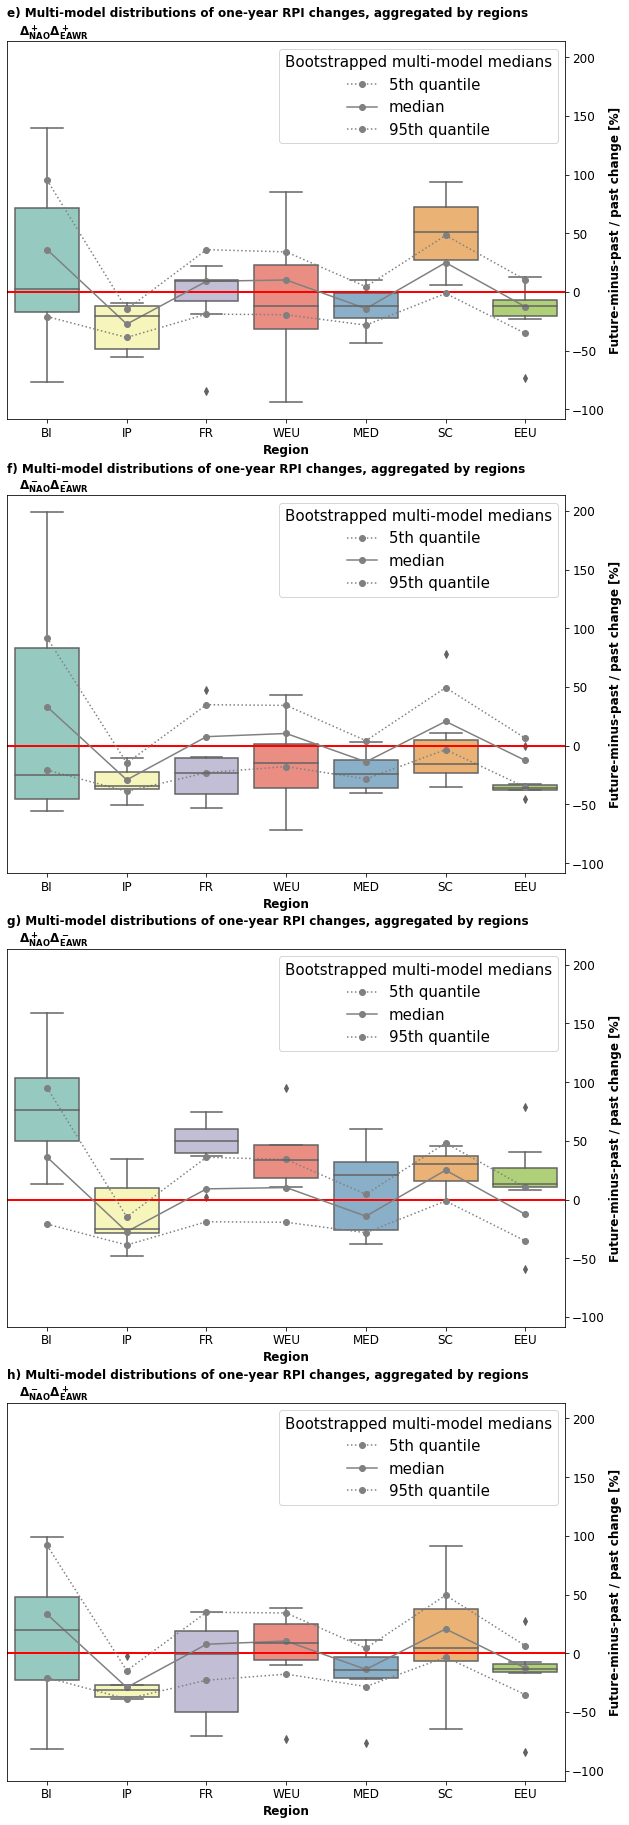

In [64]:
# Boxplots selecting models via circ scenarios, combined phases
data = stacked_ss
sel_met = "1yr_RP"
sel_phases = data["phase"].unique().tolist()
order = ["BI","IP","FR","WEU","MED","SC","EEU"] #force order of the regions
nindices = len(sel_indices)
nphases = len(sel_phases)
nplots = nindices*nphases
nrows = 4
ncols = 1
stacked_met = data.drop(["10yr_RP","20yr_RP"],axis=1)

#plotting params
saving = True
add_bootstrap = True
savelocation="results/figures/Impacts/boxplots/"
savenameimp = make_fn([impfi,caltype],bn_proc)
savefileName = make_fn(['reg_bp']+sel_indices+[str(sel_met)],savenameimp,filetype='.png')
titles = ['e) Multi-model distributions of one-year RPI changes, aggregated by regions\n   '+r'$\bf{\Delta_{NAO}^+\Delta_{EAWR}^+}$','f) Multi-model distributions of one-year RPI changes, aggregated by regions\n   '+r'$\bf{\Delta_{NAO}^-\Delta_{EAWR}^-}$',
          'g) Multi-model distributions of one-year RPI changes, aggregated by regions\n   '+r'$\bf{\Delta_{NAO}^+\Delta_{EAWR}^-}$','h) Multi-model distributions of one-year RPI changes, aggregated by regions\n   '+r'$\bf{\Delta_{NAO}^-\Delta_{EAWR}^+}$'
]
colorLabel = 'Future-minus-past / past change [%]'
stt = 'Multi-model median change in one-year RPI'  
ttsize = 12
sublabsize = 12
gllabsize = 8
cbarlabsize = 12
cbarticksize = 12
legttsize = 8

fig = plt.figure(figsize=(10*ncols,nrows*8))
#fig.suptitle('Fut vs past losses, '+format(cut,'.0E')+', '+caltype)
axs = fig.subplots(nrows=nrows,ncols=ncols,sharey=True).flatten()
iplot = 0
for i,indice in enumerate(sel_indices):

    #impfi = impf_set[i]
    stacked_ind = stacked_met[(stacked_met['scen'] == indice)]
    for j,phase in enumerate(sel_phases):
        title = titles[iplot]
        ax = axs[iplot]
        iplot += 1
        stacked_phase = stacked_ind[(stacked_ind['phase'] == phase)].copy()
        #stacked_ss = stacked_ss[sel_met]
        sns.boxplot(ax=ax,x="region", y=sel_met,data=stacked_phase,order=order,palette="Set3")
        #stacked_ind[(stacked_ind['phase'] == phase)].pivot(index='model', columns='region', values='1 yr impact').boxplot(ax=ax)
        ax.axhline(0,linewidth=2,color="r")
        ax.set_ylabel('Fut-past change (%)')
        ax.set_title(titles[i],loc='left',fontsize = cbarticksize,fontweight='bold')
        ax.set_ylabel('Future-minus-past / past change [%]',fontsize = cbarticksize,fontweight='bold')#,fontweight='bold'
        ax.set_xlabel('Region',fontsize = cbarticksize,fontweight='bold')#,fontweight='bold'
        ax.set_title(title,loc='left',fontsize = ttsize,fontweight='bold')
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.tick_params(axis='y', labelsize=cbarticksize)
        #plt.yticks(fontsize=14)
        ax.tick_params(axis='x', labelsize=cbarticksize)

        #plt.xticks(fontsize=14)
        if add_bootstrap:
            nmods_ss = len(stacked_phase.model.unique())
            stat_df = sample_dict[nmods_ss]
            stat_df.plot(ax=ax,color=['grey',"grey","grey"],style=['o:','o-','o:'],sort_columns=False)
        ax.legend(title='Bootstrapped multi-model medians',loc='upper right')#loc='center left'

if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

ValueError: min() arg is an empty sequence

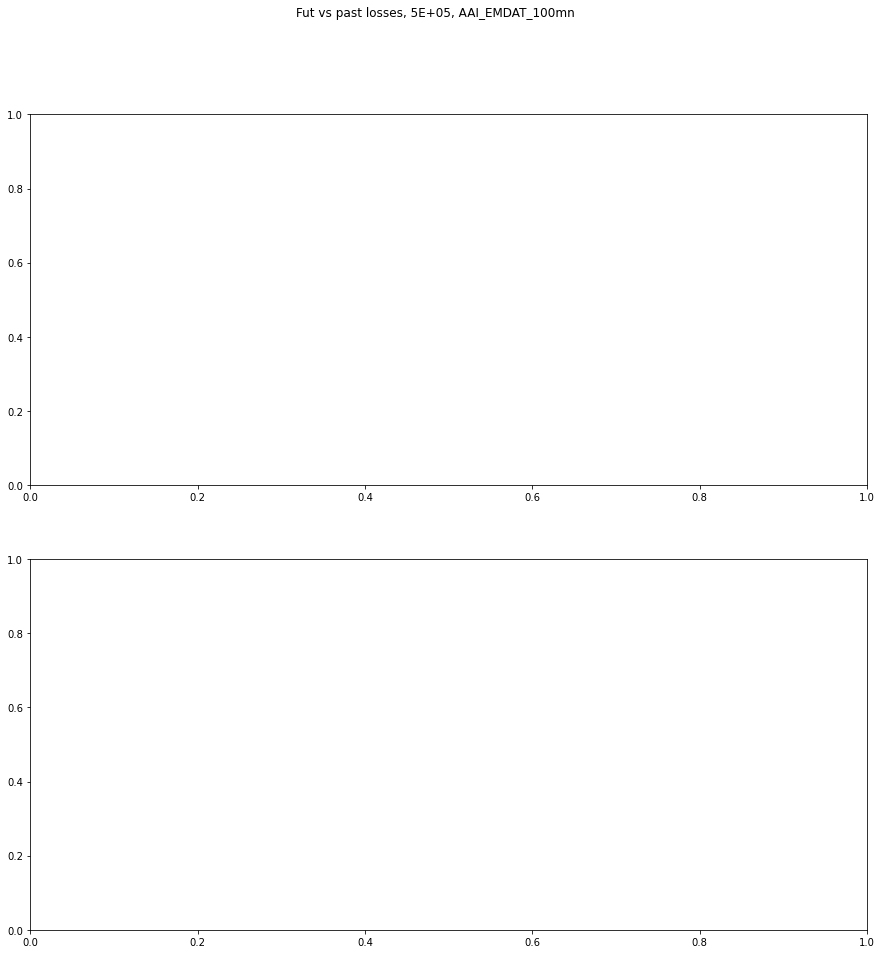

In [100]:
# fut vs past 1 plot by impf
stacked = pd.DataFrame(diff_df_scen.stack(level="region")).reset_index()
sel_met = "1 yr impact"
indices = ['NAO','EAWR']
stacked_met = stacked.drop(["10 yr impact","AAI_agg"],axis=1)
#stacked_met = stacked[sel_met]
fig = plt.figure(figsize=(15,15))
fig.suptitle('Fut vs past losses, '+format(cut,'.0E')+', '+caltype)
axs = fig.subplots(nrows=len(indices),ncols=1)
for i,ax in enumerate(axs):
    indice = indices[i]
    #impfi = impf_set[i]
    cirscen = [indice+r'$\uparrow$',indice+r'$\downarrow$']
    stacked_ss = stacked_met[(stacked_met['scen'] == cirscen[0]) | (stacked_met['scen'] == cirscen[1])]
    #stacked_ss = stacked_ss[sel_met]
    sns.boxplot(ax=ax,x="region", y=sel_met, hue="scen",data=stacked_ss, palette="Set2")
    ax.set_ylabel('Losses (USD)')
    ax.set_title(indice)
    #ax.axhline(0,linewidth=2,color="r")

KeyError: 'scen'

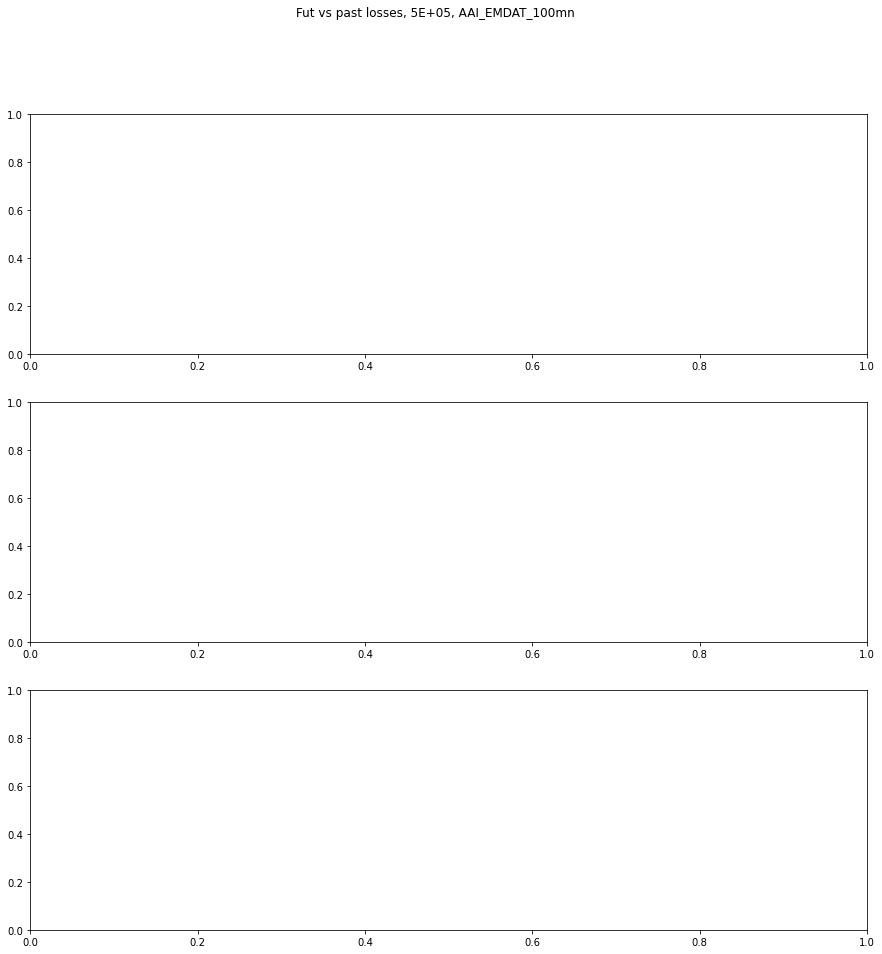

In [25]:
# fut vs past 1 plot by impf
stacked = pd.DataFrame(diff_df_scen.stack(level="region")).reset_index()
sel_met = ["1 yr impact"]
#stacked_met = stacked.drop(["10 yr impact","AAI_agg"],axis=1,level=0)
#stacked_met = stacked[sel_met]
fig = plt.figure(figsize=(15,15))
fig.suptitle('Fut vs past losses, '+format(cut,'.0E')+', '+caltype)
axs = fig.subplots(nrows=3,ncols=1)
for i,ax in enumerate(axs):
    indice = indices[i]
    impfi = impf_set[i]
    cirscen = [indice+r'$\uparrow$',indice+r'$\downarrow$']
    stacked_ss = stacked_met[(stacked_met['scen'] == cirscen[0]) | (stacked_met['scen'] == cirscen[1])]
    stacked_ss = stacked_ss[(sel_met,impfi)]
    sns.boxplot(ax=ax,x="region", y=sel_met, hue="scen",data=stacked_ss, palette="Set2")
    ax.set_ylabel('Losses (USD)')
    ax.set_title(indice)
    #ax.axhline(0,linewidth=2,color="r")


## Plot multi-impf spread

In [421]:
#select data
idx = pd.IndexSlice
met_set = ["1 yr impact","10 yr impact"]
impf_set = impf_namelist
sel_reg = regions2
subset_df = reg_df.loc[:,idx[sel_reg,:,:,impf_set]]
diff_df = subset_df.loc[:,idx[:,:,"ssp585"]]-subset_df.loc[:,idx[:,:,"historical"]].values
diff_rel_df = 100*diff_df.div(subset_df.loc[:,idx[:,:,"historical"]].values)
diff_df_ss = diff_rel_df.copy()
diff_df_ss.columns = diff_df_ss.columns.droplevel((2))
diff_df_ss.index.name = "model"
diff_df_ss.columns.name = "reg"
#take model mean
diff_ds_mmean = diff_df_ss.mean(axis=0).to_frame(name="Multimodel mean")

In [34]:
diff_ds_mmean

Multimodel mean
region metric       Impf                   
BI     AAI_agg      CubEOT        51.370329
       1 yr impact  CubEOT        68.371765
       10 yr impact CubEOT        58.945002
       AAI_agg      Em2011        34.539073
       1 yr impact  Em2011        34.584690
...                                     ...
EA     1 yr impact  Em2011       -12.710852
       10 yr impact Em2011         1.876658
       AAI_agg      Sw2010        -3.417338
       1 yr impact  Sw2010       -11.128857
       10 yr impact Sw2010        13.554521

[63 rows x 1 columns]

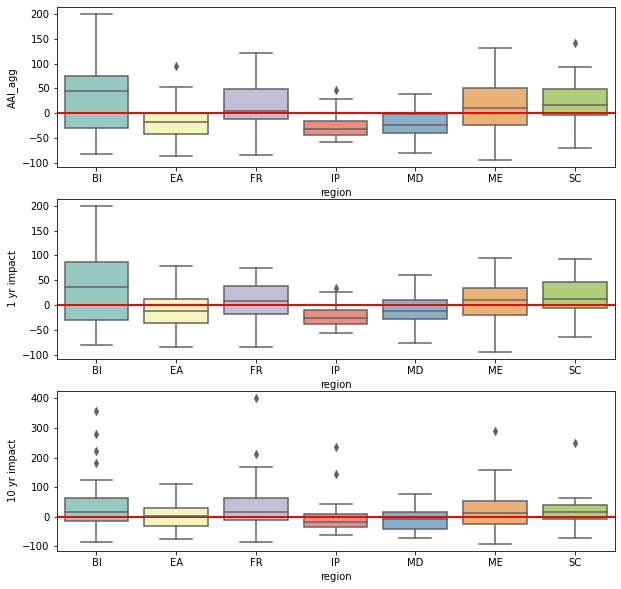

In [37]:
fig = plt.figure(figsize=(10,10))
axs = fig.subplots(nrows=3,ncols=1)
sel_met = ["AAI_agg","1 yr impact", "10 yr impact"]
for i,ax in enumerate(axs):
    met = sel_met[i]
    sns.boxplot(ax=ax,x="region", y=met,data=stacked, palette="Set3")
    ax.axhline(0,linewidth=2,color="r")